In [1]:
# --- Imports & Paths ---------------------------------------------------------
from pathlib import Path
import csv
import nd2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, util

BASE = Path("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
PLAYGROUND = BASE / "morphseq_playground"
LOOKUP_CSV = BASE / "docs" / "refactors" / "motion_blur_filtering_zstack" / "frame_nd2_lookup.csv"


# --- Lightweight IO Helpers -------------------------------------------------
def load_lookup_rows(csv_path=LOOKUP_CSV):
    """Yield dicts with all columns from frame_nd2_lookup.csv."""
    with csv_path.open() as fh:
        for row in csv.DictReader(fh):
            row["time_int"] = int(row["time_int"])
            row["nd2_series_num"] = int(row["nd2_series_num"])
            row["image_path"] = Path(row["image_path"])
            row["nd2_path"] = Path(row["nd2_path"]) if row["nd2_path"] else None
            yield row


from nd2 import ND2File

def read_nd2_frame(nd2_path: Path,
                   series_num: int,
                   time_int: int,
                   z_index: int = 0) -> np.ndarray:
    """
    Return a (Y, X) frame from the ND2 file.
    Assumes layout (T, P, Z, Y, X), which matches the printed sizes.
    """
    with ND2File(str(nd2_path)) as f:
        arr = f.to_dask()  # shape (T, P, Z, Y, X)
        frame = arr[
            time_int,
            series_num - 1,
            min(z_index, arr.shape[2] - 1)
        ].compute()
    return frame.astype(np.float32)

def get_filename(path_str: str) -> str:
    return Path(path_str).name





# --- Focus & Motion Metrics -------------------------------------------------
import cv2

def laplacian_variance(img: np.ndarray) -> float:
    """Focus metric using OpenCV Laplacian (no SciPy dependency)."""
    float_img = img.astype(np.float32, copy=False)
    lap = cv2.Laplacian(float_img, cv2.CV_32F, ksize=3)
    return float(lap.var())


def log_focus_response(img: np.ndarray, sigma: float = 1.0) -> float:
    """Approximate LoG via Gaussian blur + Laplacian in OpenCV."""
    float_img = img.astype(np.float32, copy=False)
    ksize = max(3, int(round(sigma * 6 + 1)) | 1)  # odd kernel
    blurred = cv2.GaussianBlur(float_img, (ksize, ksize), sigmaX=sigma, sigmaY=sigma)
    lap = cv2.Laplacian(blurred, cv2.CV_32F, ksize=3)
    return float(np.abs(lap).mean())



def pearson_corr(img_a, img_b):
    """Correlation in [0, 1]; handles float or uint arrays."""
    a = img_a.astype(np.float64).ravel()
    b = img_b.astype(np.float64).ravel()
    a -= a.mean(); b -= b.mean()
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    return 0.0 if denom == 0 else np.dot(a, b) / denom


# --- Quick Visualization ----------------------------------------------------
def show_frame(img, title=None):
    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title:
        plt.title(title)


def preview_with_metrics(frame_stack, metric_fn=laplacian_variance, label="Laplacian Var"):
    scores = np.array([metric_fn(f) for f in frame_stack])
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].plot(scores, marker="o")
    axes[0].set_title(f"{label} vs Frame")
    axes[0].set_xlabel("Frame idx")
    axes[0].set_ylabel(label)

    axes[1].hist(scores, bins=20)
    axes[1].set_title("Distribution")

    axes[2].plot(np.sort(scores))
    axes[2].set_title("Sorted scores")

    plt.tight_layout()
    return scores


In [2]:
# 1) Load lookup table into a DataFrame for quick selection
import pandas as pd

lookup_df = pd.read_csv(LOOKUP_CSV)
lookup_df


,category,image_path,date,well,time_int,nd2_series_num,nd2_path
0,Bad Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,B10,92,79,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
1,Bad Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,B10,96,79,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
2,Bad Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,B10,97,79,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
3,Bad Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,C04,112,30,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
4,Okay Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,C04,111,30,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
5,Okay Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,C04,24,30,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
6,Okay Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,C04,31,30,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
7,Great Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,C04,28,30,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
8,Great Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,F02,5,11,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...
9,Great Images,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...,20250912,G09,31,71,/net/trapnell/vol1/home/mdcolon/proj/morphseq/...


In [3]:
# 2) Pick an example row (by index, category, or path)
example = lookup_df.iloc[0]  # change index as needed
example


category                                                 Bad Images
image_path        /net/trapnell/vol1/home/mdcolon/proj/morphseq/...
date                                                       20250912
well                                                            B10
time_int                                                         92
nd2_series_num                                                   79
nd2_path          /net/trapnell/vol1/home/mdcolon/proj/morphseq/...
Name: 0, dtype: object

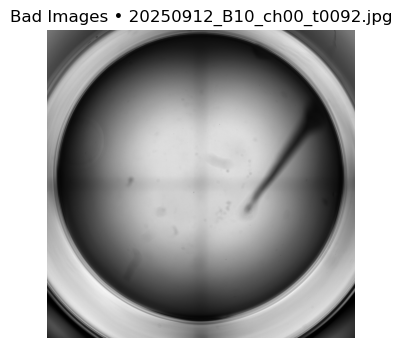

In [3]:
example = lookup_df.iloc[0]  # pick whichever row
nd2_path = Path(example["nd2_path"])
series_num = int(example["nd2_series_num"])
time_int = int(example["time_int"])

frame = read_nd2_frame(nd2_path, series_num, time_int, z_index=0)
show_frame(frame, title=f"{example['category']} • {get_filename(example['image_path'])}")


Laplacian variance: 8554798.00
Mean |LoG| (σ=1.0): 382.4885


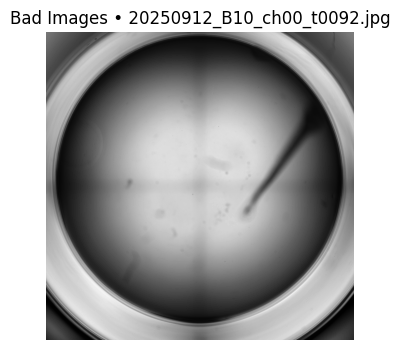

In [25]:
example = lookup_df.iloc[0]  # pick whichever row
nd2_path = Path(example["nd2_path"])
series_num = int(example["nd2_series_num"])
time_int = int(example["time_int"])

frame = read_nd2_frame(nd2_path, series_num, time_int, z_index=0)
show_frame(frame, title=f"{example['category']} • {get_filename(example['image_path'])}")

lap_score = laplacian_variance(frame)
log_score = log_focus_response(frame, sigma=1.0)

print(f"Laplacian variance: {lap_score:.2f}")
print(f"Mean |LoG| (σ=1.0): {log_score:.4f}")


array([8566918. , 8613423. , 8538456. , 8554798. , 8550568. , 8489563. ,
       8385502.5])

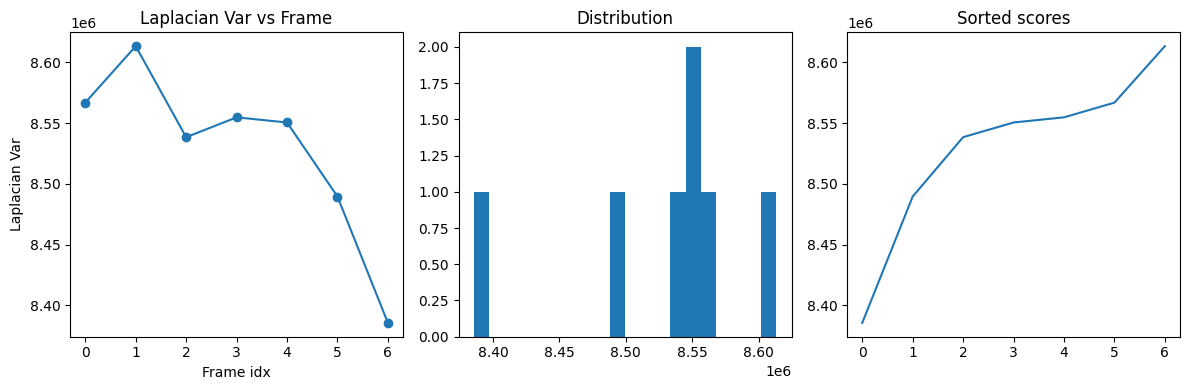

In [23]:
# 5) Build a local z-stack (e.g., +/- 3 timepoints or specific slice list)
neighbor_times = [time_int + delta for delta in range(-3, 4) if time_int + delta >= 0]
stack = [
    read_nd2_frame(nd2_path, series_num, t, z_index=0)
    for t in neighbor_times
]

scores = preview_with_metrics(stack, metric_fn=laplacian_variance, label="Laplacian Var")
scores


In [4]:
# ============================================================================
# FILTERING FUNCTIONS (Tier A Methods)
# ============================================================================

def filter_by_peak_relative(log_scores, alpha=0.7):
    """
    Keep slices with LoG score >= peak * alpha.
    
    Parameters:
    -----------
    log_scores : np.ndarray, shape (Z,)
        Mean |LoG| response per slice
    alpha : float
        Threshold as fraction of peak (0.5-0.8 typical)
    
    Returns:
    --------
    keep_mask : np.ndarray, shape (Z,) dtype bool
    """
    peak_score = log_scores.max()
    threshold = peak_score * alpha
    return log_scores >= threshold


def compute_frame_correlations(stack):
    """
    Compute Pearson correlation between consecutive frames.
    
    Parameters:
    -----------
    stack : np.ndarray, shape (Z, Y, X)
    
    Returns:
    --------
    correlations : np.ndarray, shape (Z-1,)
        corr[i] = correlation(frame[i], frame[i+1])
    """
    correlations = []
    for i in range(len(stack) - 1):
        corr = pearson_corr(stack[i], stack[i+1])
        correlations.append(corr)
    return np.array(correlations)


def filter_by_correlation_bilateral(correlations, threshold=0.9):
    """
    Flag frames involved in low-correlation pairs.
    
    CRITICAL: When corr(i, i+1) is low, BOTH frames i and i+1 are suspect.
    
    Parameters:
    -----------
    correlations : np.ndarray, shape (Z-1,)
    threshold : float
        Minimum acceptable correlation
    
    Returns:
    --------
    keep_mask : np.ndarray, shape (Z,) dtype bool
    """
    Z = len(correlations) + 1
    keep_mask = np.ones(Z, dtype=bool)
    
    bad_corr_indices = np.where(correlations < threshold)[0]
    for i in bad_corr_indices:
        keep_mask[i] = False      # flag frame i
        keep_mask[i+1] = False    # flag frame i+1
    
    return keep_mask


def hybrid_filter(stack, log_scores, alpha=0.7, corr_threshold=0.9):
    """
    Combine peak-relative and correlation filtering.
    A frame is bad if it's EITHER blurry OR unstable.
    
    Parameters:
    -----------
    stack : np.ndarray, shape (Z, Y, X)
    log_scores : np.ndarray, shape (Z,)
        Mean LoG response per slice
    alpha : float
        Peak-relative threshold
    corr_threshold : float
        Correlation threshold
    
    Returns:
    --------
    keep_mask : np.ndarray, shape (Z,) dtype bool
    metrics : dict with diagnostic info
    """
    # Filter 1: Focus
    is_sharp = filter_by_peak_relative(log_scores, alpha)
    
    # Filter 2: Motion
    correlations = compute_frame_correlations(stack)
    is_stable = filter_by_correlation_bilateral(correlations, corr_threshold)
    
    # Combine: keep only frames that are both sharp AND stable
    keep_mask = is_sharp & is_stable
    
    # Safety: never drop all frames
    if not keep_mask.any():
        keep_mask = is_sharp  # fallback to just sharpness
    
    metrics = {
        "n_total": len(stack),
        "n_sharp": int(is_sharp.sum()),
        "n_stable": int(is_stable.sum()),
        "n_kept": int(keep_mask.sum()),
        "peak_log": float(log_scores.max()),
        "mean_log": float(log_scores.mean()),
        "min_corr": float(correlations.min()) if len(correlations) > 0 else 1.0,
        "median_corr": float(np.median(correlations)) if len(correlations) > 0 else 1.0,
        "rejection_rate": 1.0 - (keep_mask.sum() / len(stack))
    }
    
    return keep_mask, metrics


# Import torch and production functions for proper focus stacking
import torch
import sys
sys.path.insert(0, str(BASE))
from src.build.export_utils import LoG_focus_stacker
from skimage import exposure

def naive_focus_stack(stack, log_scores, device="cpu"):
    """
    Proper focus stacking using the production LoG_focus_stacker.
    
    Parameters:
    -----------
    stack : np.ndarray, shape (Z, Y, X)
    log_scores : np.ndarray, shape (Z,)
        Mean LoG per slice (for metrics only, not used in stacking)
    device : str
        "cpu" or "cuda"
    
    Returns:
    --------
    focused : np.ndarray, shape (Y, X), dtype uint8
        Properly focused image, rescaled to 8-bit
    """
    # Convert to torch tensor
    stack_tensor = torch.from_numpy(stack.astype(np.float32))
    stack_tensor = stack_tensor.to(device)
    
    # Use production LoG focus stacker
    filter_size = 5  # Standard size used in pipeline
    ff, _ = LoG_focus_stacker(stack_tensor, filter_size, device)
    
    # Convert back to numpy
    ff_np = ff.cpu().numpy()
    
    # Rescale to 8-bit (same as build pipeline)
    # Clip to valid range first
    ff_clipped = np.clip(ff_np, 0, 65535)
    
    # Convert to uint16 then to uint8
    ff_u16 = ff_clipped.astype(np.uint16)
    ff_u8 = util.img_as_ubyte(ff_u16)
    
    return ff_u8

print("✅ Filtering functions loaded (using production LoG_focus_stacker)")


✅ Filtering functions loaded (using production LoG_focus_stacker)


In [5]:
# ============================================================================
# VALIDATION HELPER: Test filtering on one example
# ============================================================================

def validate_filtering_on_example(
    example_row,
    alpha_values=[0.5, 0.6, 0.7, 0.8],
    corr_values=[0.85, 0.90, 0.95],
    stack_window=5,  # +/- frames around target time
    method="hybrid"
):
    """
    Test filtering on a single example from the lookup table.
    
    Parameters:
    -----------
    example_row : pd.Series
        Row from lookup_df
    alpha_values : list of float
        Peak-relative thresholds to test
    corr_values : list of float
        Correlation thresholds to test
    stack_window : int
        Number of frames before/after to include in z-stack
    method : str
        "peak_relative", "correlation", or "hybrid"
    
    Returns:
    --------
    results : dict
        Keyed by (alpha, corr_threshold) tuples
    """
    # Load z-stack
    nd2_path = Path(example_row["nd2_path"])
    series_num = int(example_row["nd2_series_num"])
    time_int = int(example_row["time_int"])
    
    neighbor_times = [time_int + delta for delta in range(-stack_window, stack_window+1) if time_int + delta >= 0]
    stack = np.array([
        read_nd2_frame(nd2_path, series_num, t, z_index=0)
        for t in neighbor_times
    ])
    
    # Compute LoG scores for the full stack
    log_scores = np.array([log_focus_response(frame, sigma=1.0) for frame in stack])
    
    # Original focus stack (no filtering)
    ff_original = naive_focus_stack(stack, log_scores)
    
    results = {
        "metadata": {
            "category": example_row["category"],
            "well": example_row["well"],
            "time": time_int,
            "filename": get_filename(example_row["image_path"]),
            "n_frames": len(stack)
        },
        "original": {
            "image": ff_original,
            "log_scores": log_scores
        },
        "filtered": {}
    }
    
    # Test different parameter combinations
    if method == "peak_relative":
        corr_values = [None]  # Don't use correlation
    elif method == "correlation":
        alpha_values = [0.0]  # Don't filter by sharpness
    
    for alpha in alpha_values:
        for corr_thresh in corr_values:
            if method == "peak_relative":
                keep_mask = filter_by_peak_relative(log_scores, alpha)
                metrics = {
                    "n_total": len(stack),
                    "n_kept": int(keep_mask.sum()),
                    "rejection_rate": 1.0 - (keep_mask.sum() / len(stack)),
                    "peak_log": float(log_scores.max()),
                    "mean_log": float(log_scores.mean())
                }
                key = f"α={alpha}"
            elif method == "correlation":
                correlations = compute_frame_correlations(stack)
                keep_mask = filter_by_correlation_bilateral(correlations, corr_thresh)
                metrics = {
                    "n_total": len(stack),
                    "n_kept": int(keep_mask.sum()),
                    "rejection_rate": 1.0 - (keep_mask.sum() / len(stack)),
                    "min_corr": float(correlations.min()) if len(correlations) > 0 else 1.0,
                    "median_corr": float(np.median(correlations)) if len(correlations) > 0 else 1.0
                }
                key = f"corr≥{corr_thresh}"
            else:  # hybrid
                keep_mask, metrics = hybrid_filter(stack, log_scores, alpha, corr_thresh)
                key = f"α={alpha}, corr≥{corr_thresh}"
            
            # Apply filtering
            if keep_mask.sum() > 0:
                filtered_stack = stack[keep_mask]
                filtered_log_scores = log_scores[keep_mask]
                ff_filtered = naive_focus_stack(filtered_stack, filtered_log_scores)
            else:
                ff_filtered = ff_original  # fallback
                keep_mask = np.ones(len(stack), dtype=bool)
            
            results["filtered"][key] = {
                "image": ff_filtered,
                "keep_mask": keep_mask,
                "metrics": metrics
            }
    
    return results


def plot_validation_results(results, max_cols=3):
    """
    Visualize filtering results in a grid.
    """
    n_filtered = len(results["filtered"])
    n_plots = n_filtered + 1  # +1 for original
    n_cols = min(max_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    axes = np.atleast_1d(axes).flatten()
    
    # Plot original
    meta = results["metadata"]
    ax = axes[0]
    ax.imshow(results["original"]["image"], cmap="gray")
    ax.set_title(f"ORIGINAL\\n{meta['category']}\\n{meta['filename']}", fontsize=10)
    ax.axis("off")
    
    # Plot filtered versions
    for idx, (key, data) in enumerate(results["filtered"].items(), start=1):
        ax = axes[idx]
        ax.imshow(data["image"], cmap="gray")
        metrics = data["metrics"]
        title = f"{key}\\n{metrics['n_kept']}/{metrics['n_total']} frames ({metrics['rejection_rate']*100:.0f}% rejected)"
        ax.set_title(title, fontsize=9)
        ax.axis("off")
    
    # Hide unused axes
    for idx in range(n_plots, len(axes)):
        axes[idx].axis("off")
    
    plt.tight_layout()
    return fig


def create_comparison_table(all_results):
    """
    Create a DataFrame comparing all validation results.
    """
    rows = []
    for result in all_results:
        meta = result["metadata"]
        base = {
            "category": meta["category"],
            "well": meta["well"],
            "time": meta["time"],
            "n_frames": meta["n_frames"]
        }
        
        for key, data in result["filtered"].items():
            row = base.copy()
            row["filter_params"] = key
            row.update(data["metrics"])
            rows.append(row)
    
    return pd.DataFrame(rows)

print("✅ Validation helpers loaded")

✅ Validation helpers loaded


# Validation Examples

Below are examples showing how to validate filtering on the labeled images.

## Quick Test: Single Example

Test one bad image to see if filtering improves it:

Text(0.5, 1.02, 'Bad Image Test: 20250912_B10_ch00_t0092.jpg')

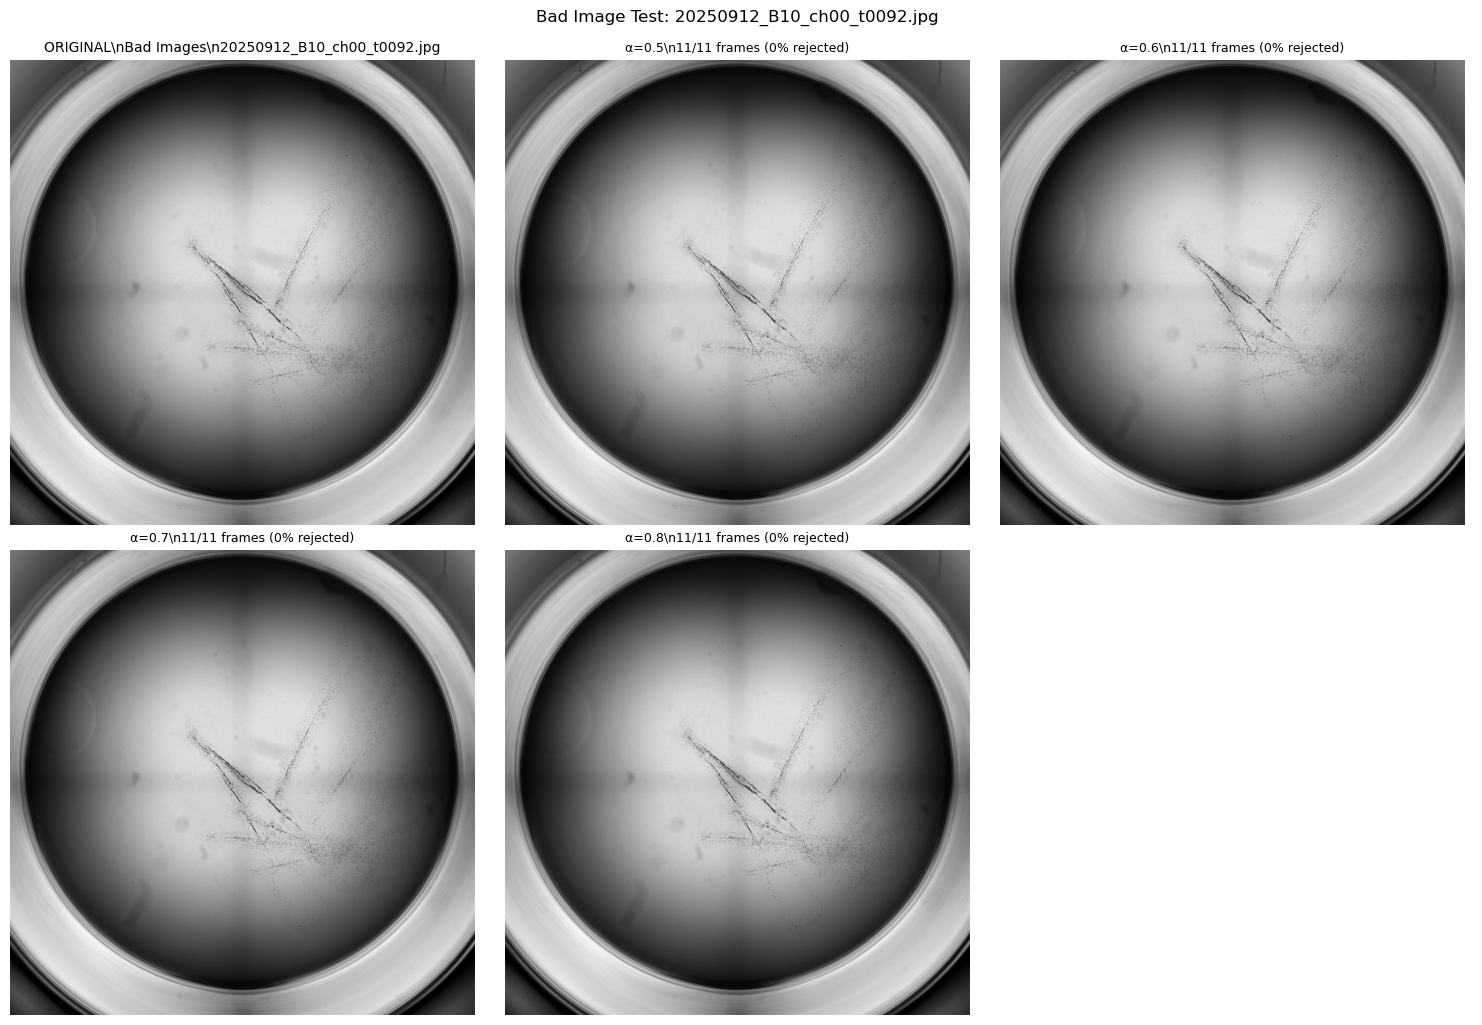

In [6]:
# Test on one BAD image
bad_example = lookup_df[lookup_df["category"] == "Bad Images"].iloc[0]

# Test peak-relative filtering only (faster)
results_bad = validate_filtering_on_example(
    bad_example,
    alpha_values=[0.5, 0.6, 0.7, 0.8],
    corr_values=[0.90],  # Just one correlation value for speed
    method="peak_relative"
)

plot_validation_results(results_bad)
plt.suptitle(f"Bad Image Test: {results_bad['metadata']['filename']}", y=1.02)

Text(0.5, 1.02, 'Great Image Test: 20250912_C04_ch00_t0028.jpg')

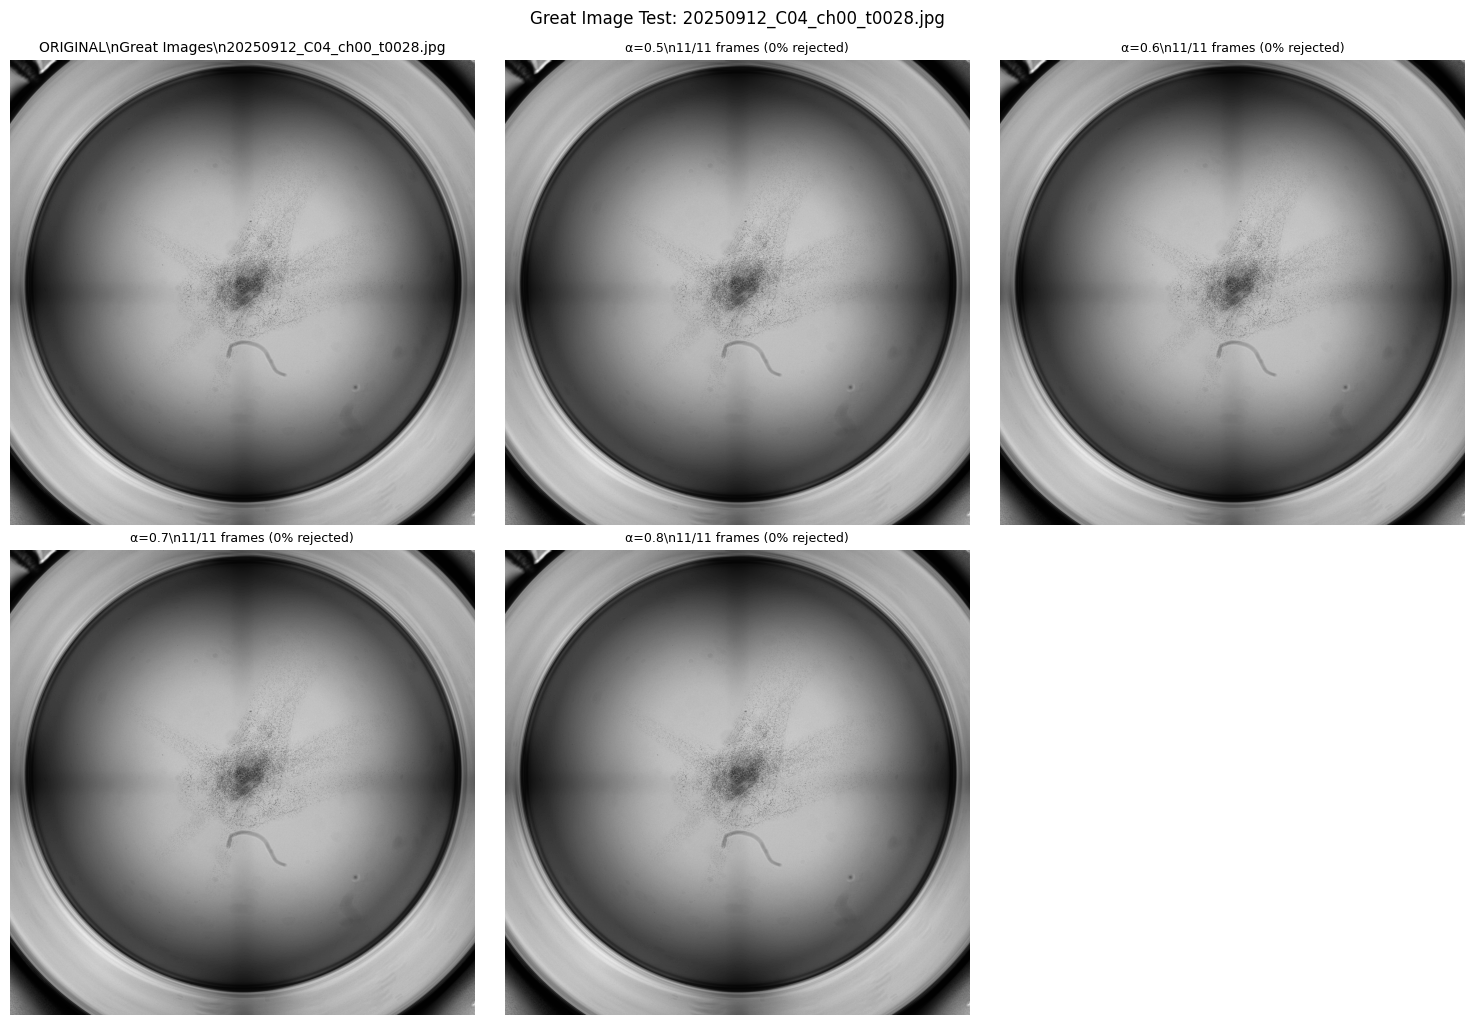

In [29]:
# Test on one GREAT image (should remain unchanged)
great_example = lookup_df[lookup_df["category"] == "Great Images"].iloc[0]

results_great = validate_filtering_on_example(
    great_example,
    alpha_values=[0.5, 0.6, 0.7, 0.8],
    corr_values=[0.90],
    method="peak_relative"
)

plot_validation_results(results_great)
plt.suptitle(f"Great Image Test: {results_great['metadata']['filename']}", y=1.02)

## Full Validation: All Examples

Test all labeled examples and create a comparison table:

In [ ]:
# Validate ALL examples in the lookup table
# WARNING: This may take 5-10 minutes depending on number of examples

all_results = []

for idx, row in lookup_df.iterrows():
    print(f"Processing {idx+1}/{len(lookup_df)}: {row['category']} - {get_filename(row['image_path'])}")
    
    try:
        result = validate_filtering_on_example(
            row,
            alpha_values=[0.6, 0.7, 0.8],  # Test 3 alpha values
            corr_values=[0.90],             # Single correlation value
            method="peak_relative"
        )
        all_results.append(result)
    except Exception as e:
        print(f"  ❌ Error: {e}")
        continue

print(f"\\n✅ Completed {len(all_results)}/{len(lookup_df)} examples")

In [ ]:
# Create comparison table
comparison_df = create_comparison_table(all_results)

# Add category column for easier grouping
comparison_df = comparison_df.sort_values(["category", "well", "time", "filter_params"])

print("\\n=== Filtering Results Summary ===\\n")
print(comparison_df.to_string(index=False))

# Show summary statistics by category
print("\\n=== Summary by Category ===\\n")
summary = comparison_df.groupby(["category", "filter_params"]).agg({
    "rejection_rate": ["mean", "std"],
    "n_kept": ["mean", "std"]
}).round(3)
print(summary)

## Visual Comparison Grid

Plot a grid showing before/after for all examples:

In [ ]:
# Plot before/after comparison for a specific alpha value
SELECTED_ALPHA = 0.7  # Change this to test different values

n_examples = len(all_results)
fig, axes = plt.subplots(n_examples, 2, figsize=(10, 5*n_examples))
if n_examples == 1:
    axes = axes.reshape(1, -1)

for idx, result in enumerate(all_results):
    meta = result["metadata"]
    
    # Original
    axes[idx, 0].imshow(result["original"]["image"], cmap="gray")
    axes[idx, 0].set_title(f"{meta['category']}\\n{meta['filename']}\\nORIGINAL", fontsize=9)
    axes[idx, 0].axis("off")
    
    # Filtered (find the one with selected alpha)
    filtered_key = f"α={SELECTED_ALPHA}"
    if filtered_key in result["filtered"]:
        filtered_data = result["filtered"][filtered_key]
        axes[idx, 1].imshow(filtered_data["image"], cmap="gray")
        metrics = filtered_data["metrics"]
        title = f"FILTERED (α={SELECTED_ALPHA})\\n{metrics['n_kept']}/{metrics['n_total']} frames\\n{metrics['rejection_rate']*100:.0f}% rejected"
        axes[idx, 1].set_title(title, fontsize=9)
    else:
        axes[idx, 1].set_title(f"No data for α={SELECTED_ALPHA}", fontsize=9)
    axes[idx, 1].axis("off")

plt.tight_layout()
plt.suptitle(f"Before/After Comparison (α={SELECTED_ALPHA})", y=1.001, fontsize=12)

---

# Testing Production Functions from export_utils.py

Now test the actual production implementations to ensure they work correctly with the pipeline:

In [ ]:
# Import production functions from the pipeline
import sys
from pathlib import Path

# Add repo root to path
REPO_ROOT = BASE  # Already defined as /net/trapnell/vol1/home/mdcolon/proj/morphseq
sys.path.insert(0, str(REPO_ROOT))

# Import the actual production functions
from src.build.export_utils import (
    compute_slice_quality_metrics,
    filter_bad_slices,
    LoG_focus_stacker_with_filtering,
    LoG_focus_stacker
)

import torch

print("✅ Successfully imported production functions from export_utils.py")
print(f"   - compute_slice_quality_metrics")
print(f"   - filter_bad_slices")
print(f"   - LoG_focus_stacker_with_filtering")
print(f"   - LoG_focus_stacker")

## Test 1: Production LoG Focus Stacker (Baseline)

First, test the standard LoG focus stacker on one of our examples:

In [ ]:
# Load a bad example
bad_ex = lookup_df[lookup_df["category"] == "Bad Images"].iloc[0]
nd2_path = Path(bad_ex["nd2_path"])
series_num = int(bad_ex["nd2_series_num"])
time_int = int(bad_ex["time_int"])

# Load z-stack (temporal neighbors)
neighbor_times = [time_int + delta for delta in range(-5, 6) if time_int + delta >= 0]
stack = np.array([
    read_nd2_frame(nd2_path, series_num, t, z_index=0)
    for t in neighbor_times
])

print(f"Loaded z-stack: {stack.shape}")
print(f"Category: {bad_ex['category']}")
print(f"File: {get_filename(bad_ex['image_path'])}")

# Convert to torch tensor
stack_tensor = torch.from_numpy(stack).float()
device = "cuda" if torch.cuda.is_available() else "cpu"
stack_tensor = stack_tensor.to(device)

print(f"Device: {device}")

# Run production LoG focus stacker (no filtering)
filter_size = 5
ff_original, log_scores_original = LoG_focus_stacker(stack_tensor, filter_size, device)

print(f"\nOriginal LoG focus stacker:")
print(f"  Output shape: {ff_original.shape}")
print(f"  LoG scores shape: {log_scores_original.shape}")
print(f"  Output dtype: {ff_original.dtype}")

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(ff_original.cpu().numpy(), cmap="gray")
plt.title(f"ORIGINAL (Production LoG_focus_stacker)\n{bad_ex['category']} - {get_filename(bad_ex['image_path'])}")
plt.axis("off")
plt.tight_layout()

## Test 2: QA Metrics Computation

Test the `compute_slice_quality_metrics()` function:

In [ ]:
# Compute QA metrics from the LoG output
qa_metrics = compute_slice_quality_metrics(
    stack_tensor,
    log_scores_original,
    enable_correlation=True
)

print("QA Metrics from Production Function:")
print(f"  Peak LoG: {qa_metrics['peak_log']:.4f}")
print(f"  Mean LoG: {qa_metrics['mean_log']:.4f}")
print(f"  Min correlation: {qa_metrics['min_corr']:.4f}")
print(f"  Median correlation: {qa_metrics['median_corr']:.4f}")
print(f"  LoG per slice shape: {qa_metrics['mean_log_per_slice'].shape}")

# Visualize LoG scores per slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(qa_metrics['mean_log_per_slice'], marker='o')
axes[0].axhline(qa_metrics['peak_log'], color='g', linestyle='--', label='Peak')
axes[0].axhline(qa_metrics['peak_log'] * 0.7, color='r', linestyle='--', label='70% threshold')
axes[0].set_xlabel('Slice index')
axes[0].set_ylabel('Mean |LoG| response')
axes[0].set_title('Sharpness per Slice')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compute and plot correlations
correlations = []
for i in range(len(stack_tensor) - 1):
    a = stack_tensor[i].cpu().numpy().ravel()
    b = stack_tensor[i+1].cpu().numpy().ravel()
    a = (a - a.mean()) / (a.std() + 1e-8)
    b = (b - b.mean()) / (b.std() + 1e-8)
    corr = np.dot(a, b) / len(a)
    correlations.append(corr)

axes[1].plot(correlations, marker='o', color='orange')
axes[1].axhline(0.9, color='r', linestyle='--', label='0.9 threshold')
axes[1].set_xlabel('Frame pair index')
axes[1].set_ylabel('Correlation')
axes[1].set_title('Frame-to-Frame Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# Identify problematic frames
print("\n⚠️ Potential Issues:")
if qa_metrics['min_corr'] < 0.9:
    bad_pairs = [i for i, c in enumerate(correlations) if c < 0.9]
    print(f"  Low correlation pairs (< 0.9): {bad_pairs}")
if qa_metrics['mean_log'] < 0.03:
    print(f"  Overall low sharpness (mean LoG = {qa_metrics['mean_log']:.4f})")

## Test 3: Filtering with Production Function

Test `LoG_focus_stacker_with_filtering()` with different methods:

In [ ]:
# Test 3 filtering methods
filtering_methods = {
    "No Filtering": {
        "enable_filtering": False
    },
    "Peak-Relative (α=0.7)": {
        "enable_filtering": True,
        "filter_method": "peak_relative",
        "filter_alpha": 0.7
    },
    "Correlation (≥0.9)": {
        "enable_filtering": True,
        "filter_method": "correlation",
        "filter_corr_threshold": 0.9
    },
    "Hybrid (α=0.7, corr≥0.9)": {
        "enable_filtering": True,
        "filter_method": "hybrid",
        "filter_alpha": 0.7,
        "filter_corr_threshold": 0.9
    }
}

results_production = {}

for method_name, params in filtering_methods.items():
    print(f"\nTesting: {method_name}")
    print(f"  Parameters: {params}")
    
    ff, log_scores, metrics = LoG_focus_stacker_with_filtering(
        stack_tensor,
        filter_size=filter_size,
        device=device,
        return_metrics=True,
        **params
    )
    
    print(f"  Result shape: {ff.shape}")
    if "n_kept" in metrics:
        print(f"  Frames kept: {metrics['n_kept']}/{metrics['n_total']} ({100*(1-metrics['rejection_rate']):.1f}%)")
        print(f"  Rejection rate: {metrics['rejection_rate']*100:.1f}%")
    
    results_production[method_name] = {
        "image": ff.cpu().numpy(),
        "metrics": metrics
    }

print("\n✅ Production filtering tests complete")

In [ ]:
# Visualize production results side-by-side
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (method_name, data) in enumerate(results_production.items()):
    ax = axes[idx]
    ax.imshow(data["image"], cmap="gray")
    
    # Build title with metrics
    title = f"{method_name}\n"
    metrics = data["metrics"]
    if "n_kept" in metrics:
        title += f"{metrics['n_kept']}/{metrics['n_total']} frames ({100*(1-metrics['rejection_rate']):.0f}% kept)\n"
    if "peak_log" in metrics:
        title += f"Peak LoG: {metrics['peak_log']:.4f}"
    
    ax.set_title(title, fontsize=10)
    ax.axis("off")

plt.suptitle(f"Production Filtering Comparison\\n{bad_ex['category']} - {get_filename(bad_ex['image_path'])}", 
             fontsize=12, y=0.995)
plt.tight_layout()

## Test 4: Batch Comparison Across Categories

Test the production functions on all 3 categories (Bad, Okay, Great):

In [ ]:
# Test one example from each category
test_categories = {
    "Bad Images": 0,    # First bad image
    "Okay Images": 0,   # First okay image  
    "Great Images": 0   # First great image
}

category_results = {}

for category, idx in test_categories.items():
    print(f"\n{'='*60}")
    print(f"Testing: {category}")
    print(f"{'='*60}")
    
    # Load example
    ex = lookup_df[lookup_df["category"] == category].iloc[idx]
    nd2_path = Path(ex["nd2_path"])
    series_num = int(ex["nd2_series_num"])
    time_int = int(ex["time_int"])
    
    # Load stack
    neighbor_times = [time_int + delta for delta in range(-5, 6) if time_int + delta >= 0]
    stack = np.array([
        read_nd2_frame(nd2_path, series_num, t, z_index=0)
        for t in neighbor_times
    ])
    stack_tensor = torch.from_numpy(stack).float().to(device)
    
    print(f"File: {get_filename(ex['image_path'])}")
    print(f"Stack shape: {stack.shape}")
    
    # Test with peak-relative filtering (α=0.7)
    ff_orig, _, metrics_orig = LoG_focus_stacker_with_filtering(
        stack_tensor, filter_size, device,
        enable_filtering=False,
        return_metrics=True
    )
    
    ff_filt, _, metrics_filt = LoG_focus_stacker_with_filtering(
        stack_tensor, filter_size, device,
        enable_filtering=True,
        filter_method="peak_relative",
        filter_alpha=0.7,
        return_metrics=True
    )
    
    print(f"\nOriginal:")
    print(f"  Peak LoG: {metrics_orig['peak_log']:.4f}")
    print(f"  Min corr: {metrics_orig['min_corr']:.4f}")
    
    print(f"\nFiltered (α=0.7):")
    print(f"  Frames kept: {metrics_filt['n_kept']}/{metrics_filt['n_total']}")
    print(f"  Rejection rate: {metrics_filt['rejection_rate']*100:.1f}%")
    print(f"  Peak LoG: {metrics_filt['peak_log']:.4f}")
    
    category_results[category] = {
        "example": ex,
        "original": {"image": ff_orig.cpu().numpy(), "metrics": metrics_orig},
        "filtered": {"image": ff_filt.cpu().numpy(), "metrics": metrics_filt}
    }

print(f"\n{'='*60}")
print("✅ Category comparison complete")
print(f"{'='*60}")

In [ ]:
# Visualize category comparison
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

for row_idx, (category, data) in enumerate(category_results.items()):
    ex = data["example"]
    orig_img = data["original"]["image"]
    filt_img = data["filtered"]["image"]
    orig_metrics = data["original"]["metrics"]
    filt_metrics = data["filtered"]["metrics"]
    
    # Original
    ax_orig = axes[row_idx, 0]
    ax_orig.imshow(orig_img, cmap="gray")
    title_orig = f"ORIGINAL\n{category}\n{get_filename(ex['image_path'])}"
    title_orig += f"\nPeak LoG: {orig_metrics['peak_log']:.4f}"
    title_orig += f"\nMin corr: {orig_metrics['min_corr']:.4f}"
    ax_orig.set_title(title_orig, fontsize=9)
    ax_orig.axis("off")
    
    # Filtered
    ax_filt = axes[row_idx, 1]
    ax_filt.imshow(filt_img, cmap="gray")
    title_filt = f"FILTERED (α=0.7)\n{category}\n{get_filename(ex['image_path'])}"
    title_filt += f"\n{filt_metrics['n_kept']}/{filt_metrics['n_total']} frames"
    title_filt += f" ({100*(1-filt_metrics['rejection_rate']):.0f}% kept)"
    title_filt += f"\nPeak LoG: {filt_metrics['peak_log']:.4f}"
    ax_filt.set_title(title_filt, fontsize=9)
    ax_filt.axis("off")

plt.suptitle("Production Function: Category Comparison", fontsize=14, y=0.995)
plt.tight_layout()

# Print summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(f"{'Category':<15} {'File':<25} {'Frames':<12} {'Rejection':<12} {'Min Corr':<10}")
print("-"*80)
for category, data in category_results.items():
    ex = data["example"]
    metrics = data["filtered"]["metrics"]
    filename = get_filename(ex['image_path'])[:22]
    frames = f"{metrics['n_kept']}/{metrics['n_total']}"
    rejection = f"{metrics['rejection_rate']*100:.1f}%"
    min_corr = f"{data['original']['metrics']['min_corr']:.3f}"
    print(f"{category:<15} {filename:<25} {frames:<12} {rejection:<12} {min_corr:<10}")
print("="*80)